# Sprint 8 · Webinar 25 · Data Analytics práctico  
**Proyecto 8:** Explorando drivers de comportamiento en **NovaRetail+** (correlaciones)  

**Programa:** Data Analytics  
**Sprint:** 8  
**Modalidad:** Práctica (proyecto paso a paso en Python)

## Fecha
> Completa aquí la fecha de la sesión.

## Objetivo de la sesión práctica (100 min)

Al finalizar esta clase, podrás **construir un análisis correlacional estructurado** para entender qué variables de comportamiento del cliente están más asociadas con el **ingreso generado** (métrica foco), sin caer en interpretaciones causales.

**Entregable en clase:** un notebook con:
- Exploración y preparación del dataset.
- Visualizaciones clave (scatterplots, heatmap).
- Correlaciones adecuadas por tipo de variable (**Pearson/Spearman**, **punto biserial**, **V de Cramér**).
- Interpretación responsable + limitaciones + recomendaciones de negocio.

## Agenda sugerida (100 minutos)

1. Contexto del proyecto + checklist de entregables (5 min)  
2. Ejercicio 1: generar y cargar el dataset (15 min)  
3. Ejercicio 2: exploración inicial + métricas y tipos de variables (15 min)  
4. Ejercicio 3: preparación de datos + supuestos documentados (20 min)  
5. Ejercicio 4: relaciones visuales (15 min)  
6. Ejercicio 5: correlaciones por tipo de variable (20 min)  
7. Ejercicio 6: interpretación responsable + reporte ejecutivo (10 min)

## Contexto del negocio (NovaRetail+)

NovaRetail+ es una plataforma de e-commerce con millones de usuarios en Latinoamérica. El equipo de Crecimiento y Retención quiere responder:

**Pregunta guía:**  
> ¿Qué factores de comportamiento del cliente están más fuertemente asociados con el ingreso generado?

⚠️ Este análisis es **correlacional y exploratorio**: nos ayuda a generar hipótesis y priorizar acciones, **no** a probar causalidad.

## Dataset del proyecto (versión sintética para clase)

En el proyecto real se trabaja con un CSV con ~15,000 filas y variables de comportamiento del cliente.  
En esta sesión vamos a **generar un dataset similar** para poder practicar el flujo completo.

**Variables (ejemplo):**
- `id_cliente` (string): identificador único  
- `edad` (num)  
- `nivel_ingreso` (num): ingreso anual estimado (proxy socioeconómico)  
- `visitas_mes` (num): visitas a app/web en el mes  
- `compras_mes` (num): compras en el mes  
- `gasto_publicidad_dirigida` (num): gasto de anuncios asignado al usuario  
- `satisfaccion` (1–5)  
- `miembro_premium` (0/1)  
- `abandono` (0/1)  
- `tipo_dispositivo` (cat): móvil/escritorio/tablet  
- `region` (cat): norte/sur/este/oeste  
- `ingreso_anual` (num): **métrica foco** (ingreso anual generado por el cliente)

---

# Ejercicio 1 · Generar el dataset y exportarlo a CSV (15 min)

**Meta:** tener un CSV listo para el análisis (como lo pide el proyecto).

1) Generar un dataframe con 15,000 clientes  
2) Guardarlo como `novaretail_comportamiento_clientes_2024.csv`  
3) (Opcional) descargarlo si estás en Google Colab

In [3]:
# 1) Imports básicos
import numpy as np
import pandas as pd

# Para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Para estadísticas y correlaciones
from scipy import stats
#from IPython.display import display

#np.random.seed(42)  # Para reproducibilidad en clase

In [4]:
# 2) Generación del dataset sintético (15,000 filas)

n = 15_000

# Variables categóricas
regiones = np.random.choice(['norte', 'sur', 'este', 'oeste'], size=n, p=[0.25, 0.25, 0.25, 0.25])
dispositivos = np.random.choice(['móvil', 'escritorio', 'tablet'], size=n, p=[0.65, 0.25, 0.10])

# Edad (con algunos valores faltantes)
edad = np.clip(np.random.normal(loc=34, scale=10, size=n).round(), 18, 70).astype(float)

# Nivel de ingreso estimado (proxy socioeconómico)
# Lo hacemos correlacionar un poco con edad y región (simulando diferencias regionales)
region_shift = pd.Series(regiones).map({'norte': 0.10, 'sur': -0.05, 'este': 0.00, 'oeste': 0.05}).values
nivel_ingreso = np.random.lognormal(mean=10.5 + region_shift, sigma=0.35, size=n)  # escala grande
nivel_ingreso = (nivel_ingreso / 1000).round(2)  # miles

# Visitas al mes (más visitas tienden a ocurrir en móvil)
base_visitas = np.random.poisson(lam=10, size=n)
visitas_mes = base_visitas + (pd.Series(dispositivos).eq('móvil').astype(int) * np.random.poisson(lam=4, size=n))

# Compras al mes (dependen de visitas + un poco de premium)
miembro_premium = (np.random.rand(n) < (0.18 + 0.05 * (visitas_mes > 20))).astype(int)
compras_mes = np.random.poisson(lam=np.clip(visitas_mes / 8, 0.5, 6), size=n) + miembro_premium

# Satisfacción (1-5), relacionada con compras y con abandono
satisfaccion_cont = 2.8 + 0.15 * compras_mes - 0.03 * (visitas_mes - 10) + np.random.normal(0, 0.8, size=n)
satisfaccion = np.clip(np.round(satisfaccion_cont), 1, 5).astype(float)

# Abandono (0/1), más probable con baja satisfacción y sin premium
prob_abandono = 0.18 - 0.03 * satisfaccion + 0.06 * (1 - miembro_premium) + np.random.normal(0, 0.01, size=n)
prob_abandono = np.clip(prob_abandono, 0.02, 0.50)
abandono = (np.random.rand(n) < prob_abandono).astype(int)

# Gasto de publicidad dirigida (no es "causa" en el mundo real; aquí lo simulamos como targeting)
# Se asigna más gasto a clientes con mayor nivel_ingreso y a premium.
gasto_publicidad_dirigida = (
    5
    + 0.03 * nivel_ingreso
    + 4 * miembro_premium
    + np.random.lognormal(mean=1.0, sigma=0.6, size=n)
).round(2)

# Ticket promedio (relacionado con nivel_ingreso, premium, y región)
ticket_promedio = (
    20
    + 0.25 * nivel_ingreso
    + 15 * miembro_premium
    + pd.Series(regiones).map({'norte': 8, 'sur': -4, 'este': 0, 'oeste': 3}).values
    + np.random.normal(0, 15, size=n)
)
ticket_promedio = np.clip(ticket_promedio, 5, None)

# Ingreso anual (métrica foco): aproximación a (compras/mes * ticket) * 12, con penalización por abandono
ingreso_anual = (compras_mes * ticket_promedio * 12) * (1 - 0.55 * abandono)
ingreso_anual = np.clip(ingreso_anual + np.random.normal(0, 250, size=n), 0, None).round(2)

# IDs
id_cliente = [f"C{str(i).zfill(6)}" for i in range(1, n+1)]

df = pd.DataFrame({
    'id_cliente': id_cliente,
    'edad': edad,
    'nivel_ingreso': nivel_ingreso,
    'visitas_mes': visitas_mes,
    'compras_mes': compras_mes,
    'gasto_publicidad_dirigida': gasto_publicidad_dirigida,
    'satisfaccion': satisfaccion,
    'miembro_premium': miembro_premium,
    'abandono': abandono,
    'tipo_dispositivo': dispositivos,
    'region': regiones,
    'ingreso_anual': ingreso_anual
})

df.head()

,id_cliente,edad,nivel_ingreso,visitas_mes,compras_mes,gasto_publicidad_dirigida,satisfaccion,miembro_premium,abandono,tipo_dispositivo,region,ingreso_anual
0,C000001,30.0,54.63,16,1,8.45,2.0,0,1,móvil,sur,409.44
1,C000002,30.0,43.33,9,1,8.74,3.0,0,0,móvil,este,393.98
2,C000003,38.0,28.28,17,2,7.35,3.0,0,0,móvil,sur,421.87
3,C000004,30.0,49.40,11,3,9.60,3.0,0,0,móvil,oeste,640.87
4,C000005,42.0,41.83,10,1,8.31,2.0,0,0,móvil,este,562.54


In [5]:
# 3) Introducimos "realismo": valores faltantes y algunos outliers (para practicar limpieza)

df.loc[df.sample(frac=0.02, random_state=1).index, 'satisfaccion'] = np.nan
df.loc[df.sample(frac=0.01, random_state=2).index, 'edad'] = np.nan

# Outliers: algunos usuarios con gasto_publicidad_dirigida extremadamente alto
outlier_idx = df.sample(frac=0.003, random_state=3).index
df.loc[outlier_idx, 'gasto_publicidad_dirigida'] *= 15

df[['edad', 'satisfaccion', 'gasto_publicidad_dirigida']].describe()

,edad,satisfaccion,gasto_publicidad_dirigida
count,14850.000000,14700.000000,15000.000000
mean,34.242088,2.978367,10.661885
std,9.574596,0.870057,9.126479
min,18.000000,1.000000,5.950000
25%,27.000000,2.000000,8.200000
50%,34.000000,3.000000,9.490000
75%,41.000000,4.000000,11.760000
max,70.000000,5.000000,309.900000


In [6]:
# 4) Exportar a CSV (igual que en el proyecto)

csv_name = "novaretail_comportamiento_clientes_2024.csv"
df.to_csv(csv_name, index=False)
print(f"CSV exportado como: {csv_name} (filas: {len(df):,})")

CSV exportado como: novaretail_comportamiento_clientes_2024.csv (filas: 15,000)


### (Opcional) ¿Cómo descargar el CSV en Google Colab?

Si estás en Colab, puedes ejecutar:

```python
from google.colab import files
files.download("novaretail_comportamiento_clientes_2024.csv")
```

En otros entornos (Jupyter local), el archivo queda guardado en la **misma carpeta** del notebook.

---

# Ejercicio 2 · Cargar y explorar el dataset (15 min)

**Meta:** entender estructura, columnas, tipos, y métricas clave.

Checklist rápido:
- ¿Cuántas filas/columnas hay?
- ¿Qué tipos de datos tenemos (numéricas vs categóricas vs binarias)?
- ¿Cuál es la variable foco?
- ¿Hay valores faltantes u outliers evidentes?

In [7]:
# Si ya tienes el CSV (proyecto real), lo cargarías así:
# df = pd.read_csv("novaretail_comportamiento_clientes_2024.csv")

df.shape

(15000, 12)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id_cliente                 15000 non-null  object 
 1   edad                       14850 non-null  float64
 2   nivel_ingreso              15000 non-null  float64
 3   visitas_mes                15000 non-null  int64  
 4   compras_mes                15000 non-null  int64  
 5   gasto_publicidad_dirigida  15000 non-null  float64
 6   satisfaccion               14700 non-null  float64
 7   miembro_premium            15000 non-null  int64  
 8   abandono                   15000 non-null  int64  
 9   tipo_dispositivo           15000 non-null  object 
 10  region                     15000 non-null  object 
 11  ingreso_anual              15000 non-null  float64
dtypes: float64(5), int64(4), object(3)
memory usage: 1.4+ MB


In [9]:
df.describe(include='all').T.head(20)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id_cliente,15000,15000,C000001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
edad,14850.0,NaN,NaN,NaN,34.242088,9.574596,18.0,27.0,34.0,41.0,70.0
nivel_ingreso,15000.0,NaN,NaN,NaN,39.699045,14.409555,9.95,29.4375,37.315,47.36,133.26
visitas_mes,15000.0,NaN,NaN,NaN,12.594467,4.058182,0.0,10.0,12.0,15.0,32.0
compras_mes,15000.0,NaN,NaN,NaN,1.7718,1.421358,0.0,1.0,2.0,3.0,12.0
gasto_publicidad_dirigida,15000.0,NaN,NaN,NaN,10.661885,9.126479,5.95,8.2,9.49,11.76,309.9
satisfaccion,14700.0,NaN,NaN,NaN,2.978367,0.870057,1.0,2.0,3.0,4.0,5.0
miembro_premium,15000.0,NaN,NaN,NaN,0.188067,0.390778,0.0,0.0,0.0,0.0,1.0
abandono,15000.0,NaN,NaN,NaN,0.136733,0.343577,0.0,0.0,0.0,0.0,1.0
tipo_dispositivo,15000,3,móvil,9695,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Valores faltantes por columna
df.isna().sum()

id_cliente                     0
edad                         150
nivel_ingreso                  0
visitas_mes                    0
compras_mes                    0
gasto_publicidad_dirigida      0
satisfaccion                 300
miembro_premium                0
abandono                       0
tipo_dispositivo               0
region                         0
ingreso_anual                  0
dtype: int64

In [10]:
# Valores faltantes por columna
df.isna().mean().sort_values(ascending=False)

satisfaccion                 0.02
edad                         0.01
nivel_ingreso                0.00
id_cliente                   0.00
visitas_mes                  0.00
compras_mes                  0.00
gasto_publicidad_dirigida    0.00
miembro_premium              0.00
abandono                     0.00
tipo_dispositivo             0.00
region                       0.00
ingreso_anual                0.00
dtype: float64

### Clasificación rápida de variables (para elegir la correlación adecuada)

- **Numéricas:** `edad`, `nivel_ingreso`, `visitas_mes`, `compras_mes`, `gasto_publicidad_dirigida`, `ingreso_anual`
- **Binarias:** `miembro_premium`, `abandono`
- **Categóricas:** `tipo_dispositivo`, `region`

---

# Ejercicio 3 · Preparación de datos y supuestos (20 min)

En el proyecto se espera que:
1) prepares datos (faltantes, tipos, outliers)  
2) **documentes supuestos** (qué hiciste y por qué)

⚠️ Esto es clave: el reporte se evalúa no solo por el resultado, sino por el **razonamiento** y la **transparencia**.

## 3.1 Limpieza básica (faltantes y tipos)

Estrategias típicas (elige una y documenta):
- Eliminar filas con faltantes (si son pocas y no sesgan mucho).
- Imputar (por ejemplo, mediana para numéricas, moda para categóricas).
- Dejar `NaN` y explicarlo (a veces es válido).

In [12]:
# Copia para no "romper" el df original durante la exploración
df_clean = df.copy()

# A) Imputar edad con mediana (simple y común)
edad_mediana = df_clean['edad'].median()
df_clean['edad'] = df_clean['edad'].fillna(edad_mediana)

In [13]:

# B) Imputar satisfacción con moda (categoría ordinal 1-5)
satisfaccion_moda = df_clean['satisfaccion'].mode(dropna=True)[0]
df_clean['satisfaccion'] = df_clean['satisfaccion'].fillna(satisfaccion_moda)


In [14]:
# C) Asegurar tipos correctos
df_clean['miembro_premium'] = df_clean['miembro_premium'].astype(int)
df_clean['abandono'] = df_clean['abandono'].astype(int)

In [15]:
df_clean.isna().sum()

id_cliente                   0
edad                         0
nivel_ingreso                0
visitas_mes                  0
compras_mes                  0
gasto_publicidad_dirigida    0
satisfaccion                 0
miembro_premium              0
abandono                     0
tipo_dispositivo             0
region                       0
ingreso_anual                0
dtype: int64

## 3.2 Tratamiento simple de outliers (winsorization)

No hay una única respuesta. Aquí usamos un enfoque sencillo:
- Calculamos percentiles 1 y 99.
- Limitamos valores fuera de ese rango.

In [16]:
col = 'gasto_publicidad_dirigida'
p01, p99 = df_clean[col].quantile([0.01, 0.99])

In [17]:
df_clean[col] = df_clean[col].clip(lower=p01, upper=p99)

df_clean[col].describe()

count    15000.000000
mean        10.218503
std          2.666888
min          6.659900
25%          8.200000
50%          9.490000
75%         11.760000
max         19.700300
Name: gasto_publicidad_dirigida, dtype: float64

## 3.3 Supuestos y decisiones (documentación)

Completa esta sección como parte del reporte final (texto + decisiones).

Ejemplo de formato:
- **Faltantes:** imputé `edad` con mediana porque el 1% faltante es bajo y la mediana es robusta a outliers.
- **Outliers:** apliqué winsorization 1%-99% en `gasto_publicidad_dirigida` para evitar que pocos casos dominen correlaciones.
- **Variable foco:** usé `ingreso_anual` como variable objetivo del análisis.

---

# Ejercicio 4 · Visualizar relaciones iniciales (15 min)

Antes de calcular correlaciones, mira patrones globales:
- Scatterplot (num vs num)
- Boxplot/violin (cat vs num)
- Heatmap (numéricas)

⚠️ La visualización puede revelar:
- no linealidad
- clusters
- outliers
- posibles relaciones espurias

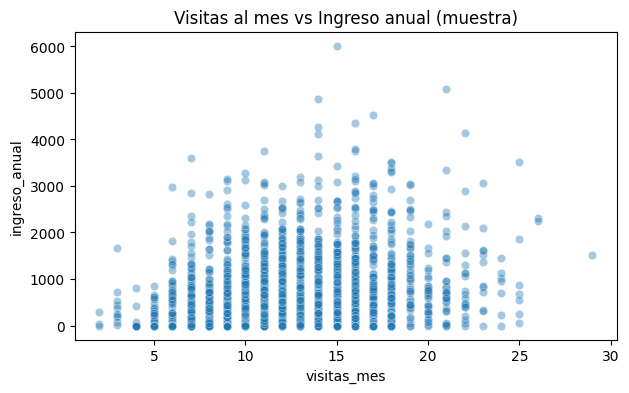

In [18]:
# 4.1 Scatter: visitas vs ingreso_anual
plt.figure(figsize=(7, 4))
sns.scatterplot(data=df_clean.sample(2000, random_state=10), x='visitas_mes', y='ingreso_anual', alpha=0.4)
plt.title("Visitas al mes vs Ingreso anual (muestra)")
plt.show()

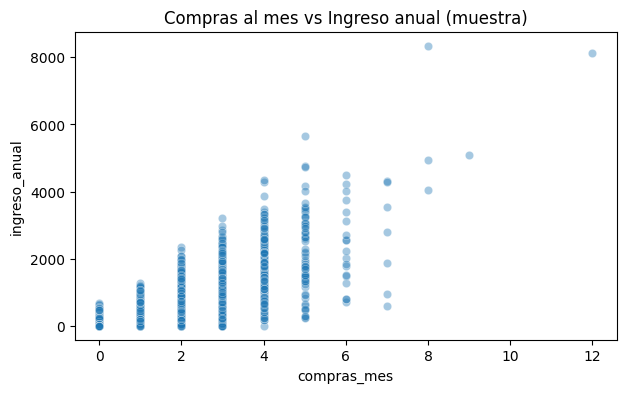

In [19]:
# 4.2 Scatter: compras vs ingreso_anual
plt.figure(figsize=(7, 4))
sns.scatterplot(data=df_clean.sample(2000, random_state=11), x='compras_mes', y='ingreso_anual', alpha=0.4)
plt.title("Compras al mes vs Ingreso anual (muestra)")
plt.show()

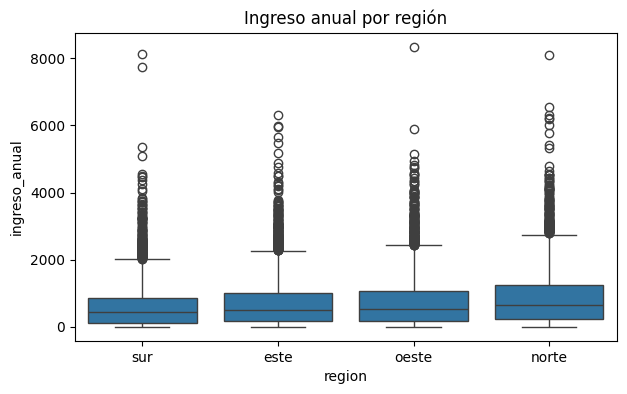

In [20]:
# 4.3 Boxplot: región vs ingreso_anual
plt.figure(figsize=(7, 4))
sns.boxplot(data=df_clean, x='region', y='ingreso_anual')
plt.title("Ingreso anual por región")
plt.show()

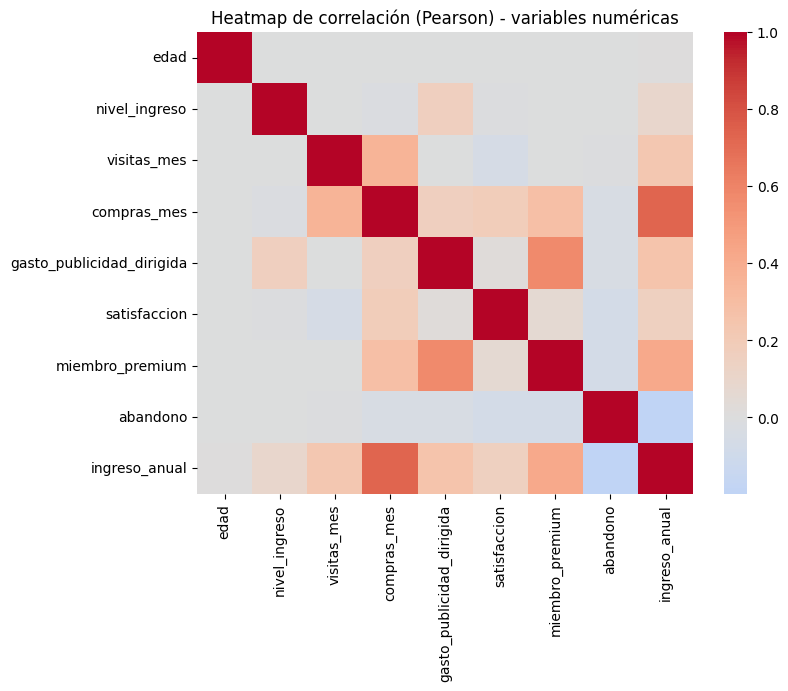

In [21]:
# 4.4 Heatmap de correlación (solo numéricas)
num_cols = df_clean.select_dtypes(include=[np.number]).columns
corr_pearson = df_clean[num_cols].corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_pearson, annot=False, cmap='coolwarm', center=0)
plt.title("Heatmap de correlación (Pearson) - variables numéricas")
plt.show()

---

# Ejercicio 5 · Calcular correlaciones adecuadas (20 min)

En el proyecto se espera que uses **métricas distintas según el tipo de variables**:

1) **Numéricas vs numéricas:**  
   - Pearson (relación lineal)  
   - Spearman (relación monótona / robusta a no linealidad)

2) **Binaria vs numérica:**  
   - Correlación **punto biserial** (equivalente a Pearson cuando una variable es 0/1)

3) **Categórica vs categórica:**  
   - Asociación con **Chi-cuadrado** y tamaño de efecto con **V de Cramér**

**Meta:** construir una tabla/resumen de correlaciones con `ingreso_anual`.

In [22]:
# 5.1 Pearson y Spearman con ingreso_anual (numéricas)

target = 'ingreso_anual'
numeric_features = ['edad', 'nivel_ingreso', 'visitas_mes', 'compras_mes', 'gasto_publicidad_dirigida', 'satisfaccion']

rows = []
for col in numeric_features:
    pearson_r, pearson_p = stats.pearsonr(df_clean[col], df_clean[target])
    spearman_r, spearman_p = stats.spearmanr(df_clean[col], df_clean[target])
    rows.append({
        'variable': col,
        'pearson_r': pearson_r, 'pearson_p': pearson_p,
        'spearman_r': spearman_r, 'spearman_p': spearman_p
    })

corr_num = pd.DataFrame(rows).sort_values('spearman_r', ascending=False)
corr_num

,variable,pearson_r,pearson_p,spearman_r,spearman_p
3,compras_mes,0.730264,0.000000e+00,0.735132,0.000000e+00
4,gasto_publicidad_dirigida,0.256841,1.410850e-224,0.235327,7.939245e-188
2,visitas_mes,0.230339,8.072613e-180,0.228601,4.483334e-177
5,satisfaccion,0.148796,5.296107e-75,0.140205,1.019263e-66
1,nivel_ingreso,0.095774,6.585131e-32,0.083288,1.655126e-24
0,edad,0.005896,4.702327e-01,0.003129,7.015786e-01


In [23]:
# 5.2 Punto biserial: binaria vs ingreso_anual

binary_features = ['miembro_premium', 'abandono']

rows = []
for col in binary_features:
    r, p = stats.pointbiserialr(df_clean[col], df_clean[target])
    rows.append({'variable': col, 'point_biserial_r': r, 'p_value': p})

corr_bin = pd.DataFrame(rows).sort_values('point_biserial_r', ascending=False)
corr_bin

,variable,point_biserial_r,p_value
0,miembro_premium,0.415822,0.000000e+00
1,abandono,-0.199254,3.763695e-134


In [24]:
# 5.3 V de Cramér: categórica vs categórica (ejemplo: region vs tipo_dispositivo)
# Nota: Para "categórica vs numérica" suele usarse ANOVA/Kruskal o eta^2,
# pero el proyecto pide explícitamente V de Cramér (cat vs cat).

from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """Calcula V de Cramér para dos variables categóricas."""
    contingency = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(contingency)
    n = contingency.sum().sum()
    r, k = contingency.shape
    phi2 = chi2 / n
    # Corrección por sesgo (opcional, pero mejora estabilidad)
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    v = np.sqrt(phi2corr / denom) if denom > 0 else np.nan
    return v, p

v_region_disp, p_region_disp = cramers_v(df_clean['region'], df_clean['tipo_dispositivo'])
v_region_disp, p_region_disp

(np.float64(0.0), np.float64(0.548169697972777))

In [25]:
# 5.4 Asociación categórica con abandono (cat vs binaria) usando V de Cramér
# Interpretación: cuánto se asocian (no "predicen") estas categorías con abandono.

for col in ['region', 'tipo_dispositivo']:
    v, p = cramers_v(df_clean[col], df_clean['abandono'])
    print(f"{col} vs abandono -> V de Cramér={v:.3f} (p={p:.3g})")

region vs abandono -> V de Cramér=0.000 (p=0.572)
tipo_dispositivo vs abandono -> V de Cramér=0.007 (p=0.251)


### Cómo leer estas correlaciones (reglas simples para clase)

- El signo (+/-) indica dirección:  
  - **+**: cuando X sube, Y tiende a subir  
  - **-**: cuando X sube, Y tiende a bajar

- La magnitud (|r|) indica fuerza (guía aproximada, depende del contexto):  
  - 0.00–0.10: muy débil  
  - 0.10–0.30: débil  
  - 0.30–0.50: moderada  
  - > 0.50: fuerte

- `p_value` pequeño sugiere que la asociación no parece “azar” (con cautela).  
  Con 15,000 filas, es normal que muchos p-values sean pequeños: importa más el **tamaño del efecto**.

---

# Ejercicio 6 · Interpretación responsable + reporte ejecutivo (10 min)

**Meta:** convertir números y gráficos en una narrativa útil para negocio.

Formato recomendado (muy parecido a lo que se evalúa en el proyecto):
1) Hallazgos (evidencia visual + numérica)  
2) Interpretación responsable (correlación ≠ causalidad)  
3) Implicaciones de negocio (acciones posibles)  
4) Supuestos y limitaciones  
5) Próximos pasos (qué análisis harías después)

In [26]:
# 6.1 Resumen automático: top variables asociadas con ingreso_anual

top_num = corr_num[['variable', 'spearman_r']].head(5)
top_bin = corr_bin[['variable', 'point_biserial_r']]

display(top_num)
display(top_bin)

,variable,spearman_r
3,compras_mes,0.735132
4,gasto_publicidad_dirigida,0.235327
2,visitas_mes,0.228601
5,satisfaccion,0.140205
1,nivel_ingreso,0.083288


,variable,point_biserial_r
0,miembro_premium,0.415822
1,abandono,-0.199254


## Plantilla de reporte (completa con tus hallazgos)

### 1) Hallazgos principales
- Variable(s) con mayor asociación positiva con `ingreso_anual`: ____
- Variable(s) con mayor asociación negativa con `ingreso_anual`: ____
- Evidencia visual (menciona gráficos específicos): ____

### 2) Interpretación responsable (sin causalidad)
- Estas asociaciones indican patrones consistentes en los datos, pero **no prueban** que una variable cause la otra.
- Posibles variables de confusión (ejemplos): promociones, estacionalidad, segmentación por región, campañas simultáneas.

### 3) Implicaciones de negocio (acciones sugeridas)
- Si `compras_mes` y `miembro_premium` se asocian fuertemente con ingreso, podríamos:
  - mejorar onboarding premium,
  - diseñar bundles o beneficios para aumentar compras recurrentes,
  - priorizar campañas a segmentos con mayor propensión.
- Si `abandono` se asocia negativamente con ingreso:
  - fortalecer retención (recordatorios, soporte, ofertas personalizadas).

### 4) Supuestos y limitaciones
- Limpieza: imputación de faltantes (edad/satisfacción) y winsorization del gasto de anuncios.
- Limitación: análisis correlacional; no controla por todas las variables; posible sesgo de selección.

### 5) Próximos pasos
- Segmentación (por región/premium) y correlaciones dentro de cada segmento.
- Modelos simples (regresión lineal/logística) para explorar drivers controlando variables.
- Diseñar experimentos A/B para validar hipótesis (causalidad).

---

## Takeaways de la sesión práctica

- Un buen análisis correlacional comienza con **limpieza** y **documentación**.
- No existe “una sola correlación”: se elige según el **tipo de variable**.
- Visualizar antes de correlacionar ayuda a evitar errores (outliers, no linealidad, segmentación).
- El valor final está en convertir hallazgos en **recomendaciones accionables** con **limitaciones claras**.

## Cierre y próximos pasos

- Asegúrate de que tu notebook tenga:
  - celdas con explicación (markdown) + resultados (tablas/gráficos)
  - supuestos y decisiones documentadas
  - un reporte ejecutivo final

- Si estás resolviendo el proyecto real, reemplaza el CSV sintético por el archivo del proyecto y repite el flujo.